In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import random
import numpy as np
import pandas as pd 
from skimage import io
from skimage import color
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread
# from dask import bag, threaded
from dask.diagnostics import ProgressBar
import cv2
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")



import keras
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import Flatten,Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image 
from keras.layers.normalization import BatchNormalization
from keras import optimizers

In [3]:
driver_details = pd.read_csv('/content/drive/MyDrive/deep_learning_project/input/driver_imgs_list.csv',na_values='na')
print(driver_details.head(5))

  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg


In [11]:
X_train=np.load('/content/drive/MyDrive/deep_learning_project/X_train.npy')
X_test=np.load('/content/drive/MyDrive/deep_learning_project/X_test.npy')
y_train=np.load('/content/drive/MyDrive/deep_learning_project/y_train.npy')
y_test=np.load('/content/drive/MyDrive/deep_learning_project/y_test.npy')

In [5]:
X_train.shape

(17263, 224, 224, 3)

In [6]:
from keras.layers import Input
vgg16_input = Input(shape = (224, 224, 3), name = 'Image_input')


## The VGG model

from keras.applications.vgg16 import VGG16, preprocess_input

#Get back the convolutional part of a VGG network trained on ImageNet
model_vgg16_conv = VGG16(weights='imagenet', include_top=False, input_tensor = vgg16_input)
model_vgg16_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
from keras.models import Model


output_vgg16_conv = model_vgg16_conv(vgg16_input)

#Add the fully-connected layers 

x = Flatten(name='flatten')(output_vgg16_conv)
# x = Dense(4096, activation='relu', name='fc1')(x)
# x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(10, activation='softmax', name='predictions')(x)

vgg16_pretrained = Model(vgg16_input,x)
vgg16_pretrained.summary()

# Compile CNN model
sgd = optimizers.SGD(lr = 0.001)
vgg16_pretrained.compile(loss='categorical_crossentropy',optimizer = sgd,metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
predictions (Dense)          (None, 10)                250890    
Total params: 14,965,578
Trainable params: 14,965,578
Non-trainable params: 0
_________________________________________________________________


In [15]:
list(range(3))

[0, 1, 2]

In [16]:
import random
index=list(range(len(y_train)))
idx=random.sample(index,10000)
X_train=X_train[idx]
y_train=y_train[idx]
X_train.shape

(10000, 224, 224, 3)

In [17]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpointer = ModelCheckpoint('vgg_weights_aug_setval_sgd.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)


datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )

# Fits the model on batches with real-time data augmentation:
vgg16_model = vgg16_pretrained.fit_generator(datagen.flow(X_train, y_train, batch_size = 64),steps_per_epoch = len(X_train) / 64, callbacks=[checkpointer, earlystopper],
                                                            epochs = 25, verbose = 1, validation_data = (X_test, y_test))

Epoch 1/25
156/156 [==============================] - 128s 817ms/step - loss: 2.2534 - accuracy: 0.1227 - val_loss: 2.2633 - val_accuracy: 0.0984

Epoch 00001: val_loss improved from inf to 2.26333, saving model to vgg_weights_aug_setval_sgd.hdf5
Epoch 2/25
156/156 [==============================] - 128s 818ms/step - loss: 2.2390 - accuracy: 0.1326 - val_loss: 2.2212 - val_accuracy: 0.1380

Epoch 00002: val_loss improved from 2.26333 to 2.22118, saving model to vgg_weights_aug_setval_sgd.hdf5
Epoch 3/25
156/156 [==============================] - 127s 814ms/step - loss: 2.2216 - accuracy: 0.1476 - val_loss: 2.2296 - val_accuracy: 0.1104

Epoch 00003: val_loss did not improve from 2.22118
Epoch 4/25
156/156 [==============================] - 129s 823ms/step - loss: 2.1827 - accuracy: 0.1773 - val_loss: 2.1550 - val_accuracy: 0.1894

Epoch 00004: val_loss improved from 2.22118 to 2.15496, saving model to vgg_weights_aug_setval_sgd.hdf5
Epoch 5/25
156/156 [==============================] -

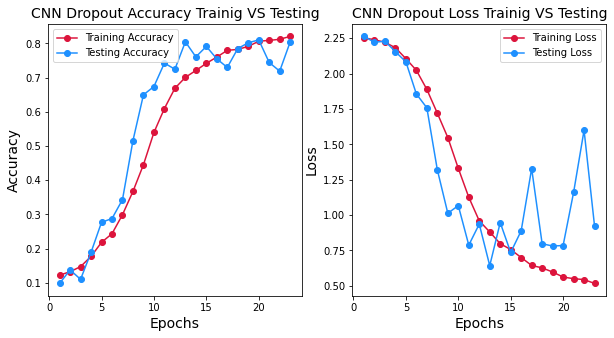

In [18]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(vgg16_pretrained.history.history['accuracy']) + 1), vgg16_pretrained.history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(vgg16_pretrained.history.history['val_accuracy']) + 1), vgg16_pretrained.history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('CNN Dropout Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(vgg16_pretrained.history.history['loss']) + 1), vgg16_pretrained.history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(vgg16_pretrained.history.history['val_loss']) + 1), vgg16_pretrained.history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')